1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

2 (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [8]:
import matplotlib.pyplot as plt
import random
from typing import TypeVar, Tuple
from typing import TypeVar, Tuple
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection
import numpy as np



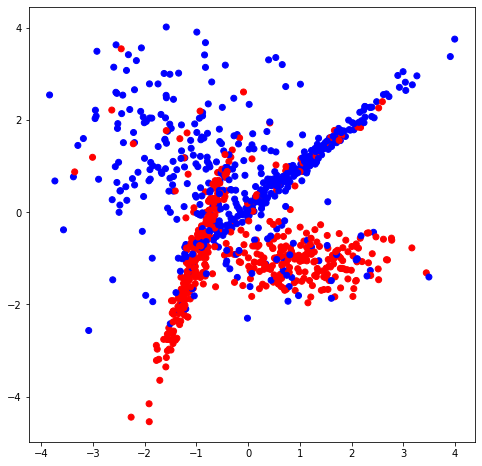

In [9]:
# сгенерируем данные
X, y = datasets.make_classification(n_samples=1000,
                                    n_features=2,
                                    n_informative=2,
                                    n_classes=2,
                                    n_redundant=0,
                                    n_clusters_per_class=2,
                                    flip_y=0.25,
                                    random_state=42)

# Разобьем выборку на обучающую и тестовую

X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.3, random_state=1)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)),
            c=y, cmap=colors)

In [18]:
class Node:
    Node = TypeVar('Node', bound='Node')

    def __init__(self,
                 index: int,
                 t: float,
                 true_branch: Node,
                 false_branch: Node) -> None:
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class ClassifierLeaf:

    def __init__(self,
                 X: np.array,
                 y: np.array) -> None:
        self.X = X
        self.y = y
        self.prediction = self.predict()

    def predict(self):
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        labels, indexes = np.unique(self.y, return_inverse=True)
        return labels[np.argmax(np.bincount(indexes))]


class RegressorLeaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        prediction = np.mean(self.labels)
        return prediction


class TreeBuilder:
    _leaf = None

    def __init__(self,
                 max_depth: int = None,
                 min_samples_leaf: int = 1,
                 min_samples_split: int = 2) -> None:
        self.max_depth = max_depth
        self.min_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self._tree = None
        self.tree_depth = 0
        self.criterion = None

    def quality(self,
                left_y: np.array,
                right_y: np.array,
                current_criteria: float) -> float:
        p = float(left_y.shape[0]) / (left_y.shape[0] + right_y.shape[0])
        return current_criteria - p * self.criterion(left_y) - (1 - p) * self.criterion(right_y)

    @staticmethod
    def split(X: np.array,
              y: np.array,
              index: int,
              t: int) -> Tuple[np.array, np.array, np.array, np.array]:

        left = np.where(X[:, index] <= t)
        right = np.where(X[:, index] > t)

        true_data, false_data = X[left], X[right]
        true_labels, false_labels = y[left], y[right]

        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):

        current_criteria = self.criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criteria)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return self._leaf(data, labels)

        if self.max_depth and self.tree_depth >= self.max_depth:
            return self._leaf(data, labels)

        if len(data) <= self.min_samples_split:
            return self._leaf(data, labels)

        self.tree_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self._leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self._tree)
            classes.append(prediction)
        return classes

    @staticmethod
    def accuracy_metric(actual, predicted):
        return np.mean(np.where(actual == predicted, 1, False)) * 100.0

        # Напечатаем ход нашего дерева

    def _print_tree(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, self._leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print(spacing + '--> True:')
        self._print_tree(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print(spacing + '--> False:')
        self._print_tree(node.false_branch, spacing + "  ")

    def print_tree(self):
        return self._print_tree(self._tree)

    def fit(self, data, labels):
        self._tree = self.build_tree(data, labels)
        return self


class DecisionTreeRegressor(TreeBuilder):
    _leaf = RegressorLeaf

    def __init__(self,
                 max_depth: int = None,
                 min_samples_leaf: int = 1,
                 min_samples_split: int = 2,
                 ) -> None:
        super().__init__(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        self.criterion = self.variance

    @staticmethod
    def variance(y: np.array) -> float:
        return float(np.std(y))


class DecisionTreeClassifier(TreeBuilder):
    _leaf = ClassifierLeaf

    def __init__(self,
                 max_depth: int = None,
                 min_samples_leaf: int = 1,
                 min_samples_split: int = 2,
                 criterion: str = 'gini') -> None:
        super().__init__(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        self.criterion = {'gini': self.gini,
                          'entropy': self.entropy}[criterion]

    @staticmethod
    def gini(y: np.array) -> float:
        #  подсчет количества объектов разных классов
        labels, indexes = np.unique(y, return_inverse=True)
        return 1 - np.sum(np.square(np.bincount(indexes) / y.shape[0]))

    @staticmethod
    def entropy(y: np.array) -> float:
        #  подсчет количества объектов разных классов
        labels, indexes = np.unique(y, return_inverse=True)
        p = np.bincount(indexes) / y.shape[0]
        return -np.sum(p * np.log2(p))


class RandomForestClassifier:
    
    RandomForestClassifier = TypeVar('RandomForestClassifier', bound='RandomForestClassifier')

    def __init__(self,
                 max_depth: int = None,
                 criterion: str = 'gini',
                 min_samples_leaf: int = 1,
                 min_samples_split: int = 2,
                 n_estimators: int = 100,
                 bootstrap: bool = True,
                 random_state: int = None) -> None:
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.bootstrap = bootstrap
        self.n_estimators = n_estimators
        self.random_state = random_state
        np.random.seed(self.random_state)
        self._forest = None
        self.oob_error = None

    def get_bootstrap(self, 
                      X: np.array) -> np.array:
        return np.random.randint(0, X.shape[0], size=(self.n_estimators, X.shape[0]))

    def get_oob(self, 
                X: np.array, 
                bootstrap: np.array) -> np.array:
        return np.array([list(set(np.arange(X.shape[0]))-set(row)) for row in bootstrap])

    def get_subsample(self, 
                      len_sample:int) -> list:
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = np.arange(len_sample).tolist()

        len_subsample = int(np.sqrt(len_sample))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample

    def random_forest(self, 
                      X: np.array, 
                      y: np.array) -> list:

        bootstrap = self.get_bootstrap(X)
        oob = self.get_oob(X, bootstrap)
        err = []
        forest = []
        if self.bootstrap:
            for b_index in bootstrap:
                forest.append(DecisionTreeClassifier(criterion=self.criterion,
                                                           max_depth=self.max_depth,
                                                           min_samples_leaf=self.min_samples_leaf,
                                                           min_samples_split=self.min_samples_split
                                                           ).fit(X[b_index], y[b_index]))

            for ob_index in oob:
                for tree in forest:
                    pred = self.predict_one(X[ob_index], tree)
                    acc = DecisionTreeClassifier.accuracy_metric(y[ob_index], pred)
                    err.append(acc)

            self.oob_error = np.mean(err)
        else:
            for _ in range(self.n_estimators):
                forest.append(DecisionTreeClassifier(criterion=self.criterion,
                                                           max_depth=self.max_depth,
                                                           min_samples_leaf=self.min_samples_leaf,
                                                           min_samples_split=self.min_samples_split
                                                           ).fit(X, y))
                
        return forest

    # функция формирования предсказания по выборке на одном дереве

    @staticmethod
    def predict_one(X: np.array, 
                    tree: Node) -> np.array:
        return tree.predict(X)

    def predict(self, 
                X: np.array) -> np.array:
        return self.tree_vote(X)

    # предсказание голосованием деревьев

    def tree_vote(self, 
                  X: np.array) -> np.array:

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self._forest:
            predictions.append(self.predict_one(X, tree))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

    def fit(self, 
            X_train: np.array, 
            y_train: np.array) -> RandomForestClassifier:
        self._forest = self.random_forest(X_train, y_train)
        return self



In [19]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
def train_graf(train_data, train_labels, test_data, test_labels, tree):
    train_accuracy = DecisionTreeClassifier.accuracy_metric(train_labels, tree.predict(train_data))
    test_accuracy = DecisionTreeClassifier.accuracy_metric(test_labels, tree.predict(test_data))
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')
    

# график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()
    
# train_graf(classification_train_data, classification_train_labels, classification_test_data, classification_test_labels, tree_gini)
# train_graf(classification_train_data,  classification_train_labels,classification_test_data, classification_test_labels, rf)

<Figure size 1152x504 with 0 Axes>

In [20]:
tree = RandomForestClassifier(criterion='gini',
                              n_estimators=5,
                              max_depth=3,
                              min_samples_leaf=2,
                              min_samples_split=2,
                              random_state=2).fit(X_train, y_train)
print(tree.oob_error)
print(DecisionTreeClassifier.accuracy_metric(y_train, tree.predict(X_train)))
print(DecisionTreeClassifier.accuracy_metric(y_test, tree.predict(X_test)))

77.45257663319892
79.28571428571428
80.0


In [21]:
forests = []
for n in [1, 3, 10, 50, 100, 200]:
    tree = RandomForestClassifier(criterion='gini',
                              n_estimators=n,
                              max_depth=3,
                              min_samples_leaf=2,
                              min_samples_split=2,
                              random_state=2).fit(X_train, y_train)
    forests.append(tree)

Число деревьев: 1


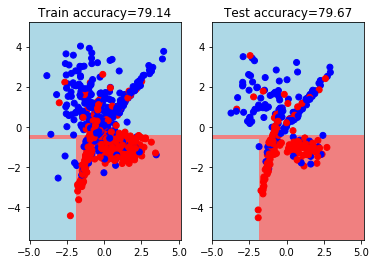

Число деревьев: 3


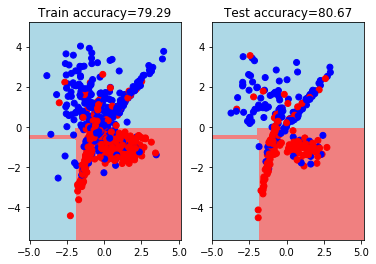

Число деревьев: 10


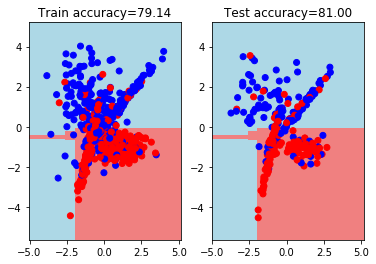

Число деревьев: 50


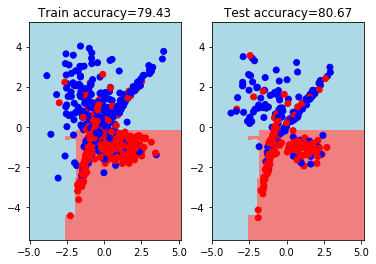

Число деревьев: 100


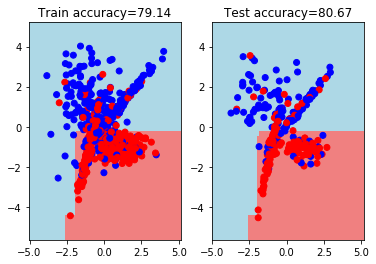

Число деревьев: 200


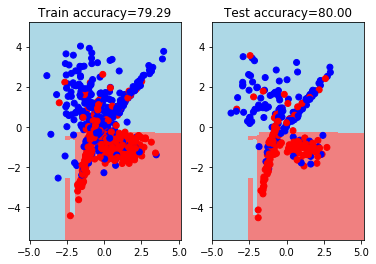

In [22]:
for rf in forests:
    print(f"Число деревьев: {rf.n_estimators}")
    train_graf(X_train,  y_train,X_test, y_test, rf)

Судя по графикам число деревьев равное 50 оптимальное, т.к. форма гиперплоскости хорошо повторяет данные, и ошибка для тестовой выборки минтмальная.